# GP Classifier Sim+ vs Real+

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample_GPC, refine_sample2, draw_density_ratio2, draw_density_ratio_GPC, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset
from torch.utils.data import TensorDataset, DataLoader

%load_ext autoreload
%autoreload 2

sim2real!!!


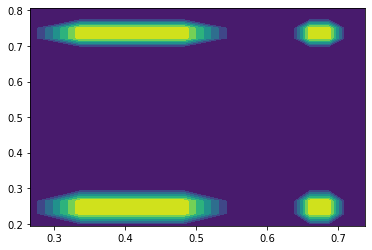

In [82]:
# USING 2D FORK DATA ===============================
n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=1000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
# train_y = torch.Tensor(train_dataset.data[:,2]).long() * 2 -1 

train_x[:,0] /= 244
train_x[:,1] /= 2*(3.14)

# y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_x[:,0] /= 244
test_x[:,1] /= 2*(3.14)

test_y = torch.Tensor(test_dataset.data[:,2]).long()
# test_y = torch.Tensor(test_dataset.data[:,2]).long() * 2 -1 
test_labels = torch.reshape(test_y, (n, n))


plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [83]:
print(train_y[train_y==1].sum())
print(train_y.shape[0])


tensor(210)
1000


In [90]:
# from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood, BernoulliLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.models import ExactGP



# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
#         self.mean_module = ZeroMean(batch_shape=torch.Size((num_classes,)))
        self.mean_module = ZeroMean()
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False)
# likelihood = BernoulliLikelihood()
model = DirichletGPModel(train_x,
#                          train_y,
                         likelihood.transformed_targets,
                         likelihood,
                         num_classes=likelihood.num_classes)

In [97]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100




# Find optimal model hyperparameters

model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


# train_x = train_x.to(device)
# model = model.to(device)
# likelihood = likelihood.to(device)
# likelihood.transformed_targets = likelihood.transformed_targets.to(device)


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(train_x))
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
#     loss = -mll(output, train_y).sum()
    loss.backward()
    if i % 5 == 0:
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item()
#             model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/100 - Loss: 4.009   lengthscale: 1.283
Iter 6/100 - Loss: 3.989   lengthscale: 1.498
Iter 11/100 - Loss: 3.985   lengthscale: 1.695
Iter 16/100 - Loss: 3.977   lengthscale: 1.887
Iter 21/100 - Loss: 3.978   lengthscale: 2.076
Iter 26/100 - Loss: 3.972   lengthscale: 2.241
Iter 31/100 - Loss: 3.961   lengthscale: 2.395
Iter 36/100 - Loss: 3.964   lengthscale: 2.538
Iter 41/100 - Loss: 3.960   lengthscale: 2.659
Iter 46/100 - Loss: 3.957   lengthscale: 2.769
Iter 51/100 - Loss: 3.960   lengthscale: 2.871
Iter 56/100 - Loss: 3.948   lengthscale: 2.968
Iter 61/100 - Loss: 3.950   lengthscale: 3.052
Iter 66/100 - Loss: 3.949   lengthscale: 3.147
Iter 71/100 - Loss: 3.942   lengthscale: 3.236
Iter 76/100 - Loss: 3.960   lengthscale: 3.320
Iter 81/100 - Loss: 3.951   lengthscale: 3.398
Iter 86/100 - Loss: 3.941   lengthscale: 3.482
Iter 91/100 - Loss: 3.936   lengthscale: 3.565
Iter 96/100 - Loss: 3

In [98]:
# model.eval()
# model.mean_module(test_x)

In [99]:
# mean = ConstantMean()
# X = torch.rand([10,3])
# mean(X).size()

In [100]:
model.eval()
likelihood.eval()
# t_x = test_x.clone().to(device)
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = likelihood(model(test_x))
#     test_dist = _test_dist.clone().cpu()
    _pred_means = test_dist.mean
    pred_means = _pred_means.clone().cpu()

tensor([[-0.5937, -0.5934, -0.5927],
        [-5.5387,  0.7321, -2.7086]])
Sample 0 : 0.007068201433867216
Sample 1 : 0.7900950312614441
Sample 2 : 0.10755819827318192


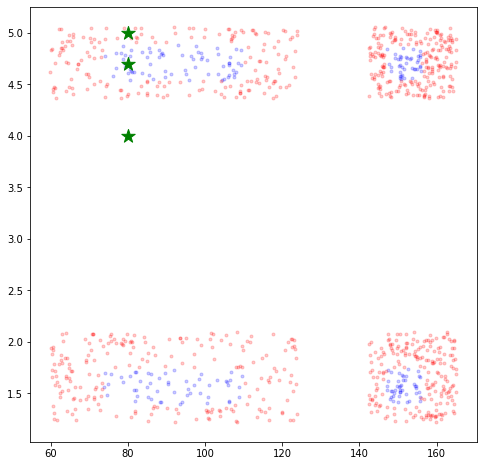

In [101]:
m = nn.Softmax(dim=0)

my_sample = torch.FloatTensor([[80, 5],
                               [80, 4.7],
                               [80, 4]])
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    means = likelihood(model(my_sample)).mean
    preds = m(means)
#     print(m(preds))

print(means)

for i, sample in enumerate(my_sample):
    print(f"Sample {i} : {preds[1,i]}")
    
fig, ax = plt.subplots(nrows=1, figsize=(8,8))
pos_masks = train_y == 1
neg_masks = ~pos_masks
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')
plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)


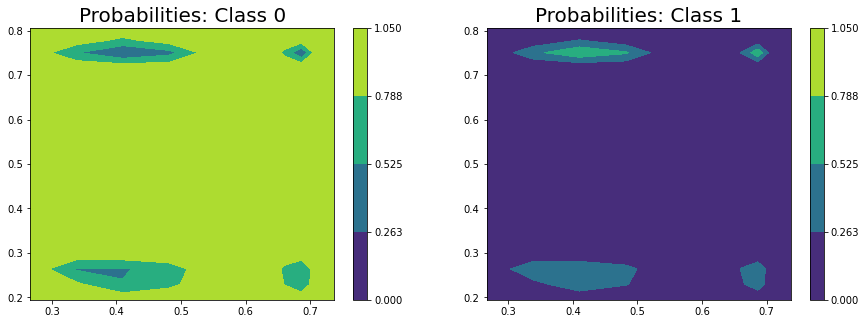

In [102]:
_pred_samples = test_dist.sample(torch.Size((256,))).exp()
pred_samples = _pred_samples.cpu()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

levels = np.linspace(0, 1.05, 5)
for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((n,n)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

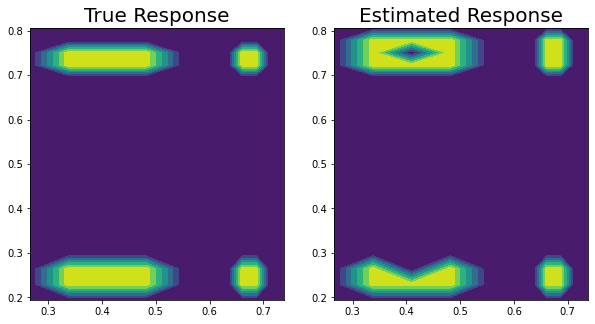

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)


logit = pred_means[1,:] - pred_means[0,:]
ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), logit.reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

In [ ]:
d_score = pred_means[1,:] - pred_means[0,:]
print(d_score)

In [ ]:
# my_sample = torch.FloatTensor([[60, 1.5],
#                                [80, 1.5]]).to(device)

# my_sample[:,0] /= 224
# my_sample[:,1] /= (2*3.14)


# model.to(device)
# model.eval()
# pred = model(my_sample).mean
# print(pred)
# # print(min(pred).item(), max(pred).item())
next(model.parameters()).is_cuda

In [ ]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [80, 1.5]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

# my_sample = my_sample.repeat(1,200)

# model.to(device)
model.eval()
# likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GPC(my_sample, model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

In [ ]:
# all_x1
# device

In [ ]:
import torch
torch.cuda.empty_cache()

pos_masks = train_y == 1
neg_masks = ~pos_masks
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)

Z, CS = draw_density_ratio_GPC(ax=ax,
                   model=model,
                   likelihood=likelihood,
#                    model=model.to(device),
#                    likelihood=likelihood.to(device),
#                    p_type='p_y_given_x',
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()